Joseph Hickey  
ASTR 400B  
2/19/2020  
Create a class which returns a mass profile of a galaxy at a given time step

In [1]:
#Import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import G
from ReadFile import Read
from CenterOfMass import CenterOfMass
G = G.to(u.kpc * u.km**2 / u.s**2 / u.Msun)

In [2]:

class MassProfile:
    
    #Initialize the class
    def __init__(self,galaxy,snapshot):
        #Put together given information to create the file name
        self.snapshot = str(snapshot)
        self.filename = galaxy + '_' + self.snapshot.zfill(3) + '.txt'
        self.gname = galaxy
        #Read in data from galaxy snapshot
        self.time, self.total, self.data = Read(self.filename)
        
        #Get info on all particles of given type and put it in new arrays
        self.m = self.data['m']
        self.x = self.data['x'] * u.kpc
        self.y = self.data['y'] * u.kpc
        self.z = self.data['z'] * u.kpc
        self.vx = self.data['vx'] * u.km / u.s
        self.vy = self.data['vy'] * u.km / u.s
        self.vz = self.data['vz'] * u.km / u.s
        
    
    
    #Calculate the mass of a particle type within an array of radii
    def MassEnclosed(self,particletype,radii):
        #particle type 1: halo, 2: disk, and 3: bulge
        #radii is an array of distances
        #Find the center of mass of the galaxy
        COM = CenterOfMass(self.filename,2)
        Pos = COM.COM_P(0.1)
        #Initialize an array of enclosed masses to contain loop outputs
        masses = np.zeros(len(radii))
        #Use only a given type of particle
        index = np.where(self.data['type'] == particletype)
        #Create an array of distances to all particles from the COM
        x1 = self.x[index].value - Pos[0].value
        y1 = self.y[index].value - Pos[1].value
        z1 = self.z[index].value - Pos[2].value
        mass = self.m[index]
        r1 = np.sqrt(x1**2 + y1**2 + z1**2)
        
        for i in range(len(radii)):
            #Find all particles of given type within the entry in radii
            partindex = np.where(r1 <= radii[i])
            particles = mass[partindex]
            #Return mass enclosed within the entry in radii
            masses[i] = sum(particles) 
            
        #Returns the array of enclosed masses with proper units
        return masses * 1e10 * u.Msun
        
    
    #Calculate the total mass within an array of radii
    def MassEnclosedTotal(self,radii):
        #Use mass enclosed function to get mass of each particle type enclosed within radii
        MEncHalo = self.MassEnclosed(1,radii)
        MEncDisk = self.MassEnclosed(2,radii)
        MEncBulge = self.MassEnclosed(3,radii)
        #Sum the masses
        total = MEncHalo + MEncDisk + MEncBulge
        #Return the array of total masses
        return 2*total
        
    
    #Calculate the mass enclosed within a Hernquist sphere
    def HernquistMass(self,radius,scale,Mhalo):
        #radius is a scalar distance from the center of the galaxy
        #scale is the scale radius and an effective size of the galaxy
        #Mhalo is the halo mass of the galaxy
        
        #Returns the Hernquist mass
        return Mhalo * radius**2 / (scale + radius)**2
        
    
    #Calculate the circular velocity of particles at given radii
    def CircularVelocity(self,particletype,radii):
        
        #masses is an array of enclosed mass at each radii
        masses = self.MassEnclosed(particletype,radii)
        Vcirc = np.sqrt(G * masses / (radii * u.kpc))
        
        #Returns the circular velocity rounded to 2 decimal places
        return np.around(Vcirc,2)
        
    
    #Calculate the circular velocity due to all particles at given radii
    def CircularVelocityTotal(self,radii):
        
        #mass is the total enclose mass at each radius
        mass = self.MassEnclosedTotal(radii)
        #This is not a simple sum of circular velocities since all particles
        #interact gravitationally and affect the velocity curve
        Vcirc = np.sqrt(G * mass / (radii * u.kpc))
        
        return Vcirc
        
    
    #Calculate the circular velocity of a Hernquist sphere
    def HernquistVCirc(self,radius,scale,Mhalo):
        #Same variables as HernquistMass
        
        #Get mass from Hernquist profile 
        mass = self.HernquistMass(radius,scale,Mhalo)
        #Same calculation as both previous velocity functions
        Vcirc = np.sqrt(G * mass / (radius * u.kpc))
        
        return Vcirc
        
    


In [3]:
#Call the class for each galaxy and assign outputs of functions as variables for plotting
MW = MassProfile('MW',0)

radii = np.arange(0.1,30.0,0.25)
MWhalo = MW.MassEnclosed(1,radii)
MWdisk = MW.MassEnclosed(2,radii)
MWbulge = MW.MassEnclosed(3,radii)
MWtotal = MW.MassEnclosedTotal(radii)

M31 = MassProfile('M31',0)

M31halo = M31.MassEnclosed(1,radii)
M31disk = M31.MassEnclosed(2,radii)
M31bulge = M31.MassEnclosed(3,radii)
M31total = M31.MassEnclosedTotal(radii)

M33 = MassProfile('M33',0)

M33halo = M33.MassEnclosed(1,radii)
M33disk = M33.MassEnclosed(2,radii)
M33bulge = M33.MassEnclosed(3,radii)
M33total = M33.MassEnclosedTotal(radii)

Text(0,0.5,'Mass Enclosed (Msun)')

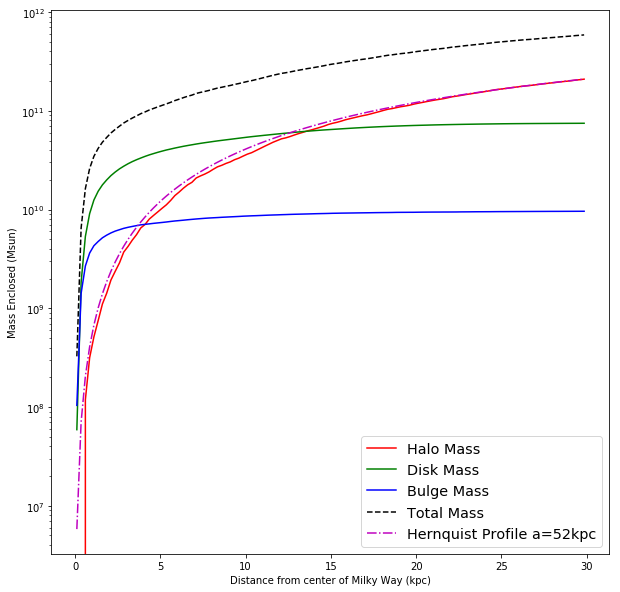

In [4]:
#Plots relevant data for the Milky Way using a log(y) axis
MWMhalo = MW.MassEnclosed(1,[500])
MWhernquistmass = MW.HernquistMass(radii,52,MWMhalo)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.semilogy(radii,MWhalo,'r',label='Halo Mass')
plt.semilogy(radii,MWdisk,'g',label='Disk Mass')
plt.semilogy(radii,MWbulge,'b',label='Bulge Mass')
plt.semilogy(radii,MWtotal,'k--',label='Total Mass')
plt.semilogy(radii,MWhernquistmass,'m-.',label='Hernquist Profile a=52kpc')
legend = ax.legend(loc='lower right',fontsize='x-large')
plt.xlabel('Distance from center of Milky Way (kpc)')
plt.ylabel('Mass Enclosed (Msun)')

Text(0,0.5,'Mass Enclosed (Msun)')

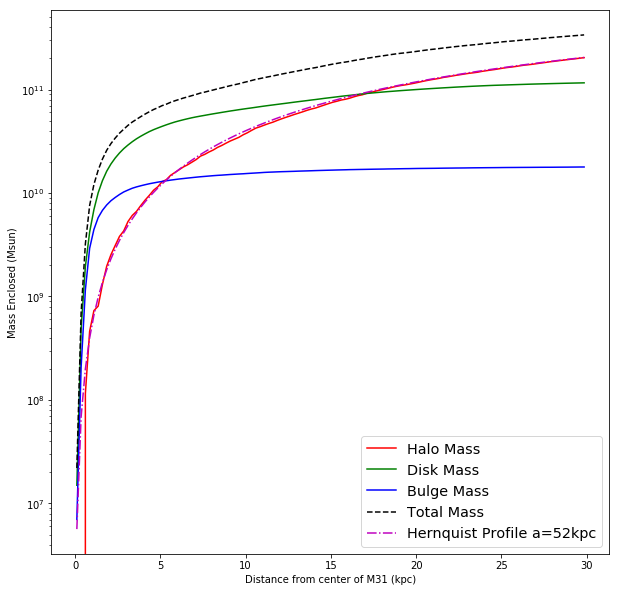

In [5]:
#Plots relevant data for the M31 using a log(y) axis
M31Mhalo = M31.MassEnclosed(1,[500])
M31hernquistmass = M31.HernquistMass(radii,52,M31Mhalo)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.semilogy(radii,M31halo,'r',label='Halo Mass')
plt.semilogy(radii,M31disk,'g',label='Disk Mass')
plt.semilogy(radii,M31bulge,'b',label='Bulge Mass')
plt.semilogy(radii,M31total,'k--',label='Total Mass')
plt.semilogy(radii,M31hernquistmass,'m-.',label='Hernquist Profile a=52kpc')
legend = ax.legend(loc='lower right',fontsize='x-large')
plt.xlabel('Distance from center of M31 (kpc)')
plt.ylabel('Mass Enclosed (Msun)')

Text(0,0.5,'Mass Enclosed (Msun)')

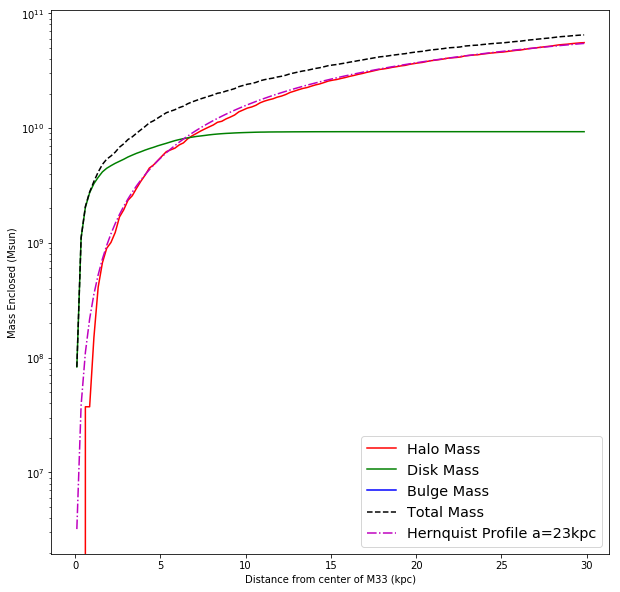

In [6]:
#Plots relevant data for the M33 using a log(y) axis
M33Mhalo = M33.MassEnclosed(1,[500])
M33hernquistmass = M33.HernquistMass(radii,23,M33Mhalo)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.semilogy(radii,M33halo,'r',label='Halo Mass')
plt.semilogy(radii,M33disk,'g',label='Disk Mass')
plt.semilogy(radii,M33bulge,'b',label='Bulge Mass')
plt.semilogy(radii,M33total,'k--',label='Total Mass')
plt.semilogy(radii,M33hernquistmass,'m-.',label='Hernquist Profile a=23kpc')
legend = ax.legend(loc='lower right',fontsize='x-large')
plt.xlabel('Distance from center of M33 (kpc)')
plt.ylabel('Mass Enclosed (Msun)')

In [7]:
#Assigns velocity function outputs to variables
MWVhalo = MW.CircularVelocity(1,radii)
MWVdisk = MW.CircularVelocity(2,radii)
MWVbulge = MW.CircularVelocity(3,radii)
MWVtotal = MW.CircularVelocityTotal(radii)

M31Vhalo = M31.CircularVelocity(1,radii)
M31Vdisk = M31.CircularVelocity(2,radii)
M31Vbulge = M31.CircularVelocity(3,radii)
M31Vtotal = M31.CircularVelocityTotal(radii)

M33Vhalo = M33.CircularVelocity(1,radii)
M33Vdisk = M33.CircularVelocity(2,radii)
M33Vbulge = M33.CircularVelocity(3,radii)
M33Vtotal = M33.CircularVelocityTotal(radii)

#These scale values were determined by matching the Hernquist profile to the halo mass profile for each galaxy
#Since M31 is close to the same mass as the Milky Way, it is not surprising their scales are close or equal
MWHernquistVcirc = MW.HernquistVCirc(radii,52,MWMhalo)
M31HernquistVcirc = M31.HernquistVCirc(radii,52,M31Mhalo)
M33HernquistVcirc = M33.HernquistVCirc(radii,23,M33Mhalo)

Text(0,0.5,'Circular Velocity (km/s)')

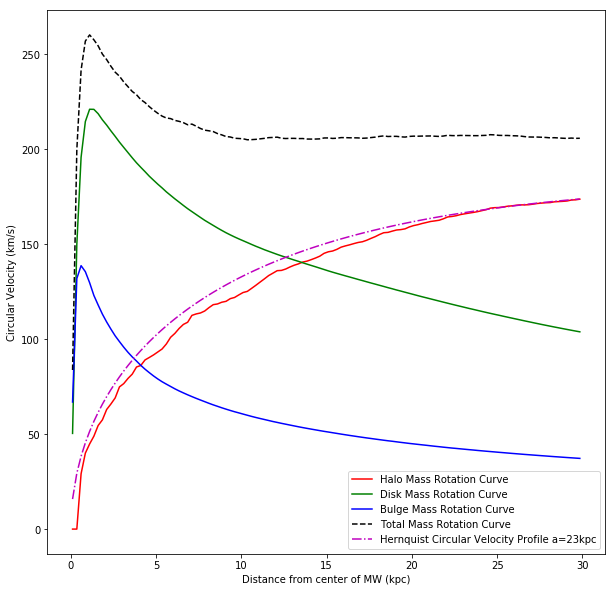

In [8]:
#Plots relevant data for the Milky Way
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.plot(radii,MWVhalo,'r',label='Halo Mass Rotation Curve')
plt.plot(radii,MWVdisk,'g',label='Disk Mass Rotation Curve')
plt.plot(radii,MWVbulge,'b',label='Bulge Mass Rotation Curve')
plt.plot(radii,MWVtotal,'k--',label='Total Mass Rotation Curve')
plt.plot(radii,MWHernquistVcirc,'m-.',label='Hernquist Circular Velocity Profile a=23kpc')
legend = ax.legend(loc='lower right')
plt.xlabel('Distance from center of MW (kpc)')
plt.ylabel('Circular Velocity (km/s)')

Text(0,0.5,'Circular Velocity (km/s)')

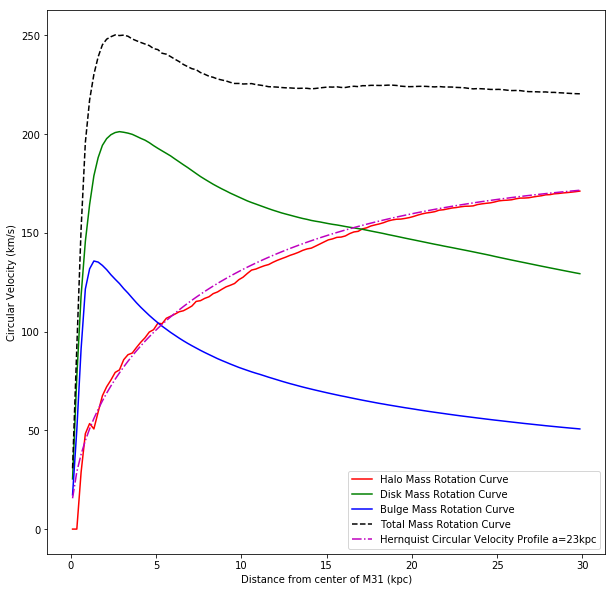

In [9]:
#Plots relevant data for the M31
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.plot(radii,M31Vhalo,'r',label='Halo Mass Rotation Curve')
plt.plot(radii,M31Vdisk,'g',label='Disk Mass Rotation Curve')
plt.plot(radii,M31Vbulge,'b',label='Bulge Mass Rotation Curve')
plt.plot(radii,M31Vtotal,'k--',label='Total Mass Rotation Curve')
plt.plot(radii,M31HernquistVcirc,'m-.',label='Hernquist Circular Velocity Profile a=23kpc')
legend = ax.legend(loc='lower right')
plt.xlabel('Distance from center of M31 (kpc)')
plt.ylabel('Circular Velocity (km/s)')

Text(0,0.5,'Circular Velocity (km/s)')

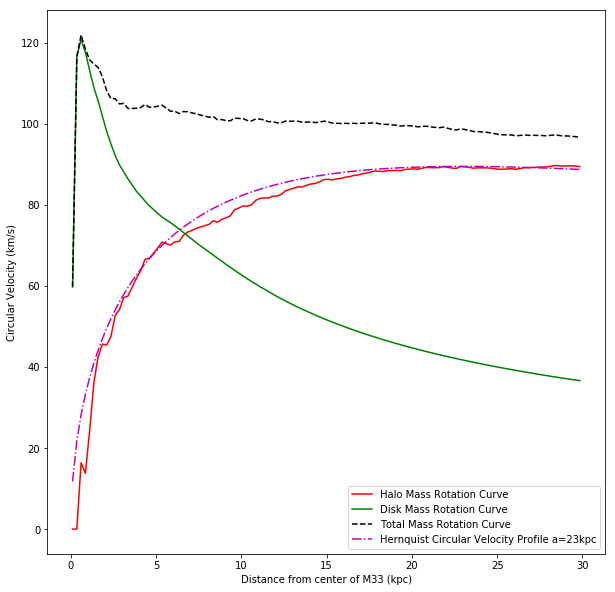

In [10]:
#Plots relevant data for the M33
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.plot(radii,M33Vhalo,'r',label='Halo Mass Rotation Curve')
plt.plot(radii,M33Vdisk,'g',label='Disk Mass Rotation Curve')

plt.plot(radii,M33Vtotal,'k--',label='Total Mass Rotation Curve')
plt.plot(radii,M33HernquistVcirc,'m-.',label='Hernquist Circular Velocity Profile a=23kpc')
legend = ax.legend(loc='lower right')
plt.xlabel('Distance from center of M33 (kpc)')
plt.ylabel('Circular Velocity (km/s)')